In [1]:
import torch
from torch import nn
import torchaudio
import torch.nn.functional as F
from torchvision.transforms import Compose
from torch.utils.data import DataLoader
from time import time

import matplotlib.pyplot as plt

import librosa
import numpy as np

from pathlib import Path

%cd ../io
from load import readAudio, readAnnotations, readMidi, compute_log_filterbank, compute_log_filter_spectrogram
from convert_slakh import MIDI_MAPPING
%cd ..
from preprocess import compute_normalization, create_transform, invert_log_filter_spectrogram
from evaluate import compute_peaks, compute_predictions, f_measure
from models import VisionTransformer, ADTOF_FrameAttention, ADTOF_FrameRNN
%cd notebooks

import IPython

/Users/runarfosse/Library/Python/3.11/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/runarfosse/Desktop/OneDrive - University of Bergen/Master Thesis/io


/Users/runarfosse/Library/Python/3.11/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/runarfosse/Desktop/OneDrive - University of Bergen/Master Thesis
/Users/runarfosse/Desktop/OneDrive - University of Bergen/Master Thesis/notebooks


/Users/runarfosse/Library/Python/3.11/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
def plot_prediction(model: nn.Module, data: torch.Tensor, label: torch.Tensor, transforms: Compose) -> None:

    # Predict using the model
    with torch.no_grad():
        if transforms:
            data = transforms(data)
        activation = F.sigmoid(model(data))
        prediction = compute_peaks(activation)
        
        predictions = compute_predictions(prediction, label)
        val_f1_micro, val_f1_macro, val_f1_class = f_measure(predictions)
        print("Predictions:", predictions)
        print("Class F1s:", val_f1_class)
        print("Total F1:", val_f1_micro)

    # And plot
    fig, ax = plt.subplots(3)

    ax[0].set_title("Data (400 frames, 84 bins, 1 channel)")
    ax[0].imshow(data.squeeze().T)
    ax[0].set_xlabel("Frames (hop size: 10ms)")
    ax[0].set_ylabel("Frequency bins")
    ax[0].invert_yaxis()

    ax[1].set_title("Target (400 frames, 5 classes)")
    ax[1].imshow(label.squeeze().T.round(), aspect=10, interpolation="nearest")
    ax[1].set_xlabel("Frames (hop size: 10ms)")
    ax[1].set_ylabel("Classes")
    ax[1].set_yticks([0, 1, 2, 3, 4], ("BD", "SD", "TT", "HH", "CY+RD"))
    ax[1].invert_yaxis()

    ax[2].set_title("Prediction (400 frames, 5 classes)")
    ax[2].imshow(prediction.squeeze().T.round(), aspect=10, interpolation="nearest")
    ax[2].set_xlabel("Frames (hop size: 10ms)")
    ax[2].set_ylabel("Classes")
    ax[2].set_yticks([0, 1, 2, 3, 4], ("BD", "SD", "TT", "HH", "CY+RD"))
    ax[2].invert_yaxis()

    fig.tight_layout()
    plt.show()

In [3]:
# Get the path to the dataset directory
path = Path("../../Master Thesis Dataset").resolve()

In [4]:
# Load a model
model_path = Path("../study/Architecture/Vision Transformer/ADTOF-YT").resolve()
config = torch.load(model_path / "config.pt")
model = VisionTransformer(**config["parameters"]).eval()
state_dict = torch.load(model_path / "model.pt", map_location="cpu")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
# Parse the audio and midi file
spectrogram = readAudio(path / "Bauklötze" / "mix.wav")
label = readMidi(path / "Bauklötze" / "annotation.mid", MIDI_MAPPING, spectrogram.shape[0], 5)

# Create a transform
transforms = create_transform(**config["transforms"], channels_last=True)

# "Batch" the data
data = torch.unsqueeze(spectrogram[0:400], dim=0)
label = torch.unsqueeze(label[0:400], dim=0)

Predictions: tensor([[2., 3., 3.],
        [3., 2., 0.],
        [7., 4., 3.],
        [0., 0., 0.],
        [1., 0., 0.]])
Class F1s: tensor([0.4000, 0.7500, 0.6667, 0.0000, 1.0000])
Total F1: tensor(0.6341)


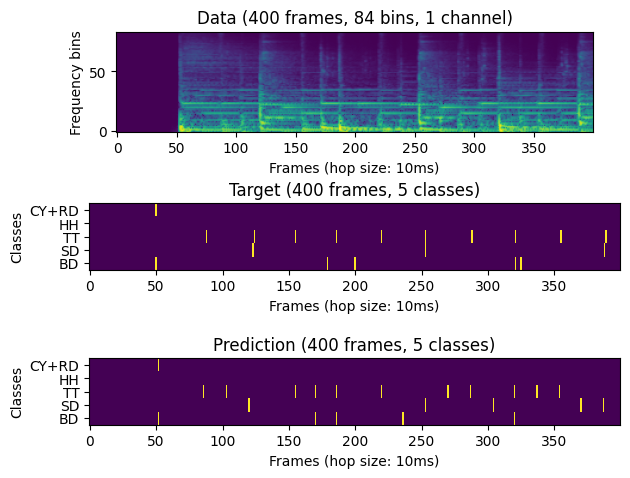

In [6]:
# And plot it
plot_prediction(model, data, label, transforms)

Predictions: tensor([[11.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [36.,  5.,  4.],
        [ 0.,  0.,  0.]])
Class F1s: tensor([1.0000, 0.0000, 0.0000, 0.8889, 0.0000])
Total F1: tensor(0.9126)


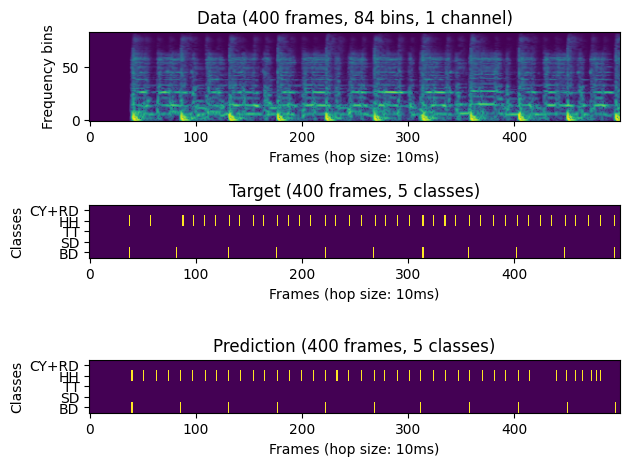

In [7]:
# Predict with a different song
spectrogram = readAudio(path / "Life Will Change" / "mix.wav")
label = readMidi(path / "Life Will Change" / "annotation.mid", MIDI_MAPPING, spectrogram.shape[0], 5)
data = torch.unsqueeze(spectrogram[0:500], dim=0)
label =  torch.unsqueeze(label[0:500], dim=0)

plot_prediction(model, data, label, transforms)

Predictions: tensor([[ 8.,  7.,  7.],
        [ 5.,  9.,  1.],
        [ 0.,  1.,  0.],
        [14.,  7.,  7.],
        [ 1.,  0.,  0.]])
Class F1s: tensor([0.5333, 0.5000, 0.0000, 0.6667, 1.0000])
Total F1: tensor(0.5895)


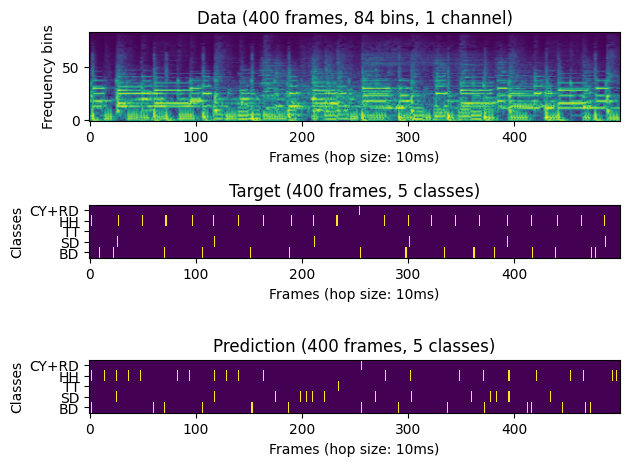

In [10]:
# Predict with a different song
spectrogram = readAudio(path / "Escape" / "mix.wav")
label = readMidi(path / "Escape" / "annotation.mid", MIDI_MAPPING, spectrogram.shape[0], 5)
data = torch.unsqueeze(spectrogram[2000:2500], dim=0)
label =  torch.unsqueeze(label[2000:2500], dim=0)

plot_prediction(model, data, label, transforms)